# 02 — Modeling Pipeline
**Author:** Joe Todaro

Reproducible Pipeline, time-aware split, three models (LR/RF/XGB), proper metrics (MAE/RMSE/R²), interpretability (importances), and saved artifacts.

## 1) Setup

In [1]:
import os, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    print('⚠️ XGBoost not available; will skip that model.')

import joblib

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['axes.grid']=True

DATA_INTERIM = '../data/interim'
DATA_PROCESSED = '../data/processed'
P_SD = f'{DATA_INTERIM}/station_day.csv'
Path(DATA_PROCESSED).mkdir(parents=True, exist_ok=True)
assert os.path.exists(P_SD), f'Missing file: {P_SD}'

sd = pd.read_csv(P_SD, low_memory=False)
sd['date'] = pd.to_datetime(sd['date'], errors='coerce')
sd = sd.dropna(subset=['date'])

print('Loaded:', sd.shape, '| stations:', sd['station'].nunique(), '| date range:', sd['date'].min(), '→', sd['date'].max())

Loaded: (15032, 6) | stations: 428 | date range: 2023-09-01 00:00:00 → 2024-06-20 00:00:00


## 2) Feature Engineering (lags & rolling)

In [2]:
df = sd.sort_values(['station','date']).copy()

if 'dow' not in df.columns: df['dow'] = df['date'].dt.weekday
if 'is_weekend' not in df.columns: df['is_weekend'] = df['dow'].isin([5,6]).astype(int)
if 'is_holiday' not in df.columns: df['is_holiday'] = 0

grp = df.groupby('station', group_keys=False)
df['lag1'] = grp['ridership'].shift(1)
df['lag7'] = grp['ridership'].shift(7)
df['roll7_mean'] = grp['ridership'].rolling(7, min_periods=3).mean().reset_index(level=0, drop=True)
df['roll28_mean'] = grp['ridership'].rolling(28, min_periods=7).mean().reset_index(level=0, drop=True)

df = df.dropna(subset=['ridership','lag1','lag7','roll7_mean','roll28_mean']).copy()

top_stations = df['station'].value_counts().head(100).index
df['station_lumped'] = np.where(df['station'].isin(top_stations), df['station'], 'OTHER')

print('Post-feature shape:', df.shape, '| OHE stations:', len(top_stations), '+ OTHER')

Post-feature shape: (12036, 11) | OHE stations: 100 + OTHER


## 3) Train / Validation / Test Split (time-based)

In [3]:
dates_sorted = np.sort(df['date'].unique())
n = len(dates_sorted)
train_end = dates_sorted[int(n*0.8)-1]
val_end   = dates_sorted[int(n*0.9)-1]

train = df[df['date'] <= train_end].copy()
val   = df[(df['date'] > train_end) & (df['date'] <= val_end)].copy()
test  = df[df['date'] > val_end].copy()

print('Split dates:')
print('  Train ≤', train_end, ' | rows:', len(train))
print('  Val   ≤', val_end, ' | rows:', len(val))
print('  Test  >', val_end, ' | rows:', len(test))

num_features = ['lag1','lag7','roll7_mean','roll28_mean']
cat_features = ['station_lumped','dow','is_weekend','is_holiday']
target = 'ridership'

X_train, y_train = train[num_features + cat_features], train[target]
X_val,   y_val   = val[num_features + cat_features],   val[target]
X_test,  y_test  = test[num_features + cat_features],  test[target]

Split dates:
  Train ≤ 2024-03-13T00:00:00.000000000  | rows: 7419
  Val   ≤ 2024-05-01T00:00:00.000000000  | rows: 2156
  Test  > 2024-05-01T00:00:00.000000000  | rows: 2461


## 4) Preprocess & Version‑Safe Metrics

In [4]:
import sklearn
print('scikit-learn version:', sklearn.__version__)

def rmse_safe(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def metrics_report(y_true, y_pred):
    return {'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': rmse_safe(y_true, y_pred),
            'R2': r2_score(y_true, y_pred)}

# OneHotEncoder compatibility
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('ohe', ohe)])

preprocess = ColumnTransformer(
    transformers=[('num', numeric_transformer, num_features),
                  ('cat', categorical_transformer, cat_features)]
)

scikit-learn version: 1.7.1


## 5) Models: Linear Regression, Random Forest, XGBoost

In [5]:
results = {}

# Linear Regression
pipe_lr = Pipeline(steps=[('prep', preprocess), ('model', LinearRegression())])
pipe_lr.fit(X_train, y_train)
pred_lr_val  = pipe_lr.predict(X_val)
pred_lr_test = pipe_lr.predict(X_test)
results['LinearRegression_val']  = metrics_report(y_val,  pred_lr_val)
results['LinearRegression_test'] = metrics_report(y_test, pred_lr_test)

# Random Forest
pipe_rf = Pipeline(steps=[('prep', preprocess),
                         ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])
param_rf = {'model__n_estimators':[200,400],
            'model__max_depth':[10,20,None],
            'model__min_samples_leaf':[1,3]}
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)
gs_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_
pred_rf_val  = best_rf.predict(X_val)
pred_rf_test = best_rf.predict(X_test)
results['RandomForest_val']  = metrics_report(y_val,  pred_rf_val)
results['RandomForest_test'] = metrics_report(y_test, pred_rf_test)

# XGBoost
best_xgb = None
if HAS_XGB:
    pipe_xgb = Pipeline(steps=[('prep', preprocess),
                              ('model', XGBRegressor(
                                  n_estimators=600, max_depth=6, learning_rate=0.05,
                                  subsample=0.8, colsample_bytree=0.8,
                                  random_state=42, tree_method='hist', n_jobs=-1
                              ))])
    param_xgb = {'model__max_depth':[4,6,8],
                 'model__learning_rate':[0.05,0.1],
                 'model__n_estimators':[400,800]}
    gs_xgb = GridSearchCV(pipe_xgb, param_grid=param_xgb, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    gs_xgb.fit(X_train, y_train)
    best_xgb = gs_xgb.best_estimator_
    pred_xgb_val  = best_xgb.predict(X_val)
    pred_xgb_test = best_xgb.predict(X_test)
    results['XGBoost_val']  = metrics_report(y_val,  pred_xgb_val)
    results['XGBoost_test'] = metrics_report(y_test, pred_xgb_test)
else:
    print('Skipping XGBoost — not installed.')

import json
print(json.dumps(results, indent=2))

{
  "LinearRegression_val": {
    "MAE": 1358.2664012852551,
    "RMSE": 1987.8770604474944,
    "R2": -18.110083973752
  },
  "LinearRegression_test": {
    "MAE": 1178.2984162478374,
    "RMSE": 1761.9240557025928,
    "R2": -14.280435311285842
  },
  "RandomForest_val": {
    "MAE": 219.57665700371058,
    "RMSE": 672.4391231752261,
    "R2": -1.1867014735543178
  },
  "RandomForest_test": {
    "MAE": 152.14290938642827,
    "RMSE": 413.45455334110113,
    "R2": 0.15857208722227756
  },
  "XGBoost_val": {
    "MAE": 326.4996643066406,
    "RMSE": 825.4412077792094,
    "R2": -2.2950034141540527
  },
  "XGBoost_test": {
    "MAE": 227.84365844726562,
    "RMSE": 551.7302329943502,
    "R2": -0.4983557462692261
  }
}


## 6) Select Final Model & Evaluate on Test

In [6]:
def pick_best(res):
    best_name, best_rmse = None, 1e18
    for k,v in res.items():
        if k.endswith('_val'):
            if v['RMSE'] < best_rmse:
                best_name, best_rmse = k.replace('_val',''), v['RMSE']
    return best_name

best_name = pick_best(results)
print('Selected final model:', best_name)

model_map = {'LinearRegression': pipe_lr, 'RandomForest': best_rf, 'XGBoost': best_xgb}
final_model = model_map.get(best_name)

# Fit on train+val, evaluate on test
trainval = pd.concat([train, val], ignore_index=True)
X_trv = trainval[num_features + cat_features]
y_trv = trainval[target]
final_model.fit(X_trv, y_trv)

pred_test = final_model.predict(X_test)
final_metrics = metrics_report(y_test, pred_test)
print('Final test metrics:', final_metrics)

Selected final model: RandomForest
Final test metrics: {'MAE': 144.39313795205203, 'RMSE': 390.16496073878795, 'R2': 0.250696285677214}


## 7) Visualizations — Predictions vs Actuals

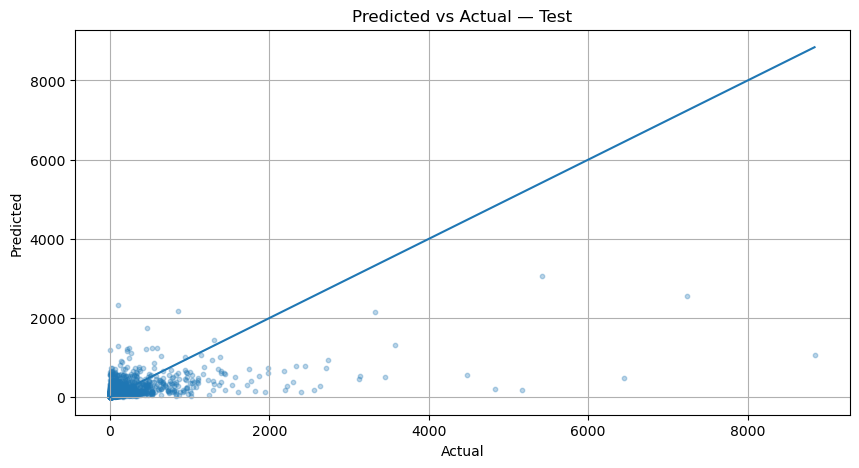

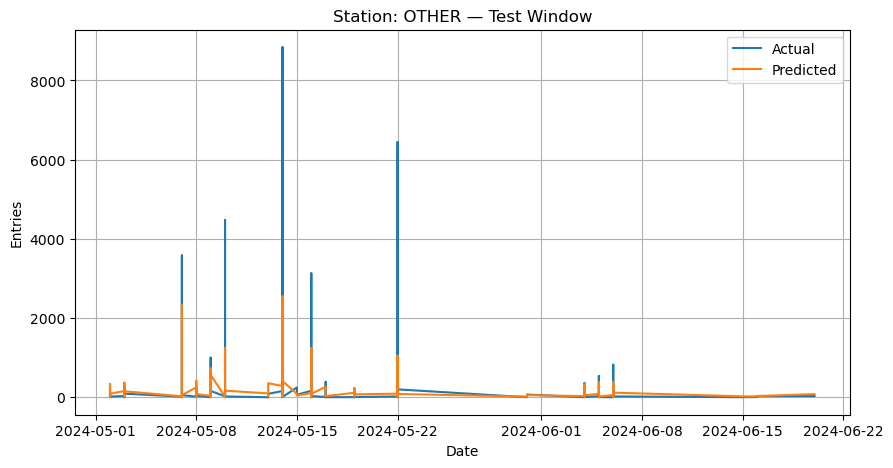

In [8]:
# Scatter
fig, ax = plt.subplots()
ax.scatter(y_test, pred_test, s=10, alpha=0.3)
lims=[0, max(y_test.max(), pred_test.max())]; ax.plot(lims, lims)
ax.set_title('Predicted vs Actual — Test'); ax.set_xlabel('Actual'); ax.set_ylabel('Predicted'); plt.show()

# Time plot for a representative station
# pick the most common station in the test split
sample_station = X_test['station_lumped'].mode().iloc[0]

# boolean mask for that station, aligned to test/X_test index
mask = (X_test['station_lumped'] == sample_station).to_numpy()

# build a tidy frame using the test set (actuals) + predictions
series = test.loc[mask, ['date', 'station', 'ridership']].copy()
series = series.rename(columns={'ridership': 'actual'})
series['pred'] = pred_test[mask]  # pred_test is a numpy array

# ensure chronological
series['date'] = pd.to_datetime(series['date'])
series = series.sort_values('date')

# plot
fig, ax = plt.subplots()
ax.plot(series['date'], series['actual'], label='Actual')
ax.plot(series['date'], series['pred'], label='Predicted')
ax.set_title(f'Station: {sample_station} — Test Window')
ax.set_ylabel('Entries'); ax.set_xlabel('Date'); ax.legend()
plt.show()

## 8) Feature Importance (tree models)

,feature,importance
2,roll7_mean,0.689112
0,lag1,0.117290
3,roll28_mean,0.059189
1,lag7,0.052688
106,dow_1,0.034271
109,dow_4,0.020055
111,dow_6,0.009445
110,dow_5,0.003208
105,dow_0,0.002938
107,dow_2,0.001831


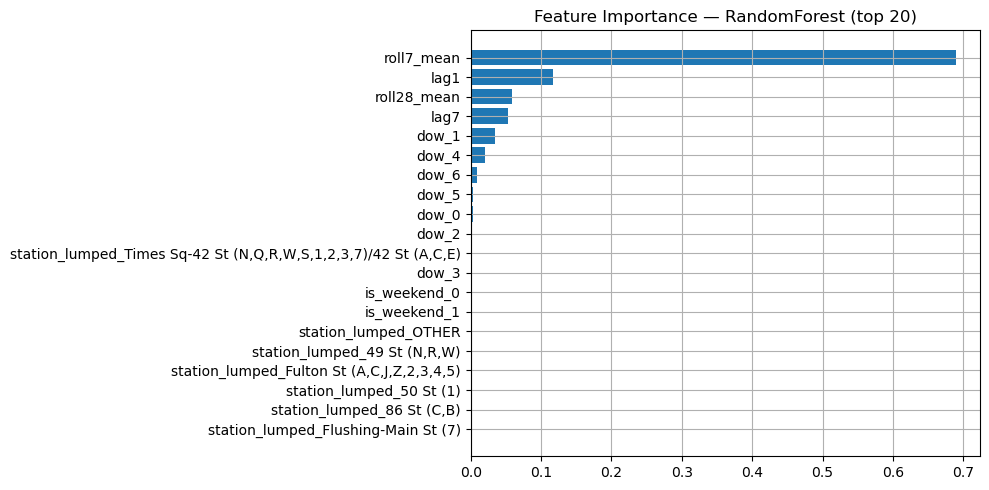

In [9]:
model_name = best_name
feature_importances = None
if model_name in ['RandomForest','XGBoost']:
    prep = final_model.named_steps['prep']
    ohe = prep.named_transformers_['cat'].named_steps['ohe']
    num_names = ['lag1','lag7','roll7_mean','roll28_mean']
    cat_names = list(ohe.get_feature_names_out(['station_lumped','dow','is_weekend','is_holiday']))
    all_names = num_names + cat_names
    importances = final_model.named_steps['model'].feature_importances_
    feature_importances = pd.DataFrame({'feature': all_names, 'importance': importances}).sort_values('importance', ascending=False)
    display(feature_importances.head(20))
    top = feature_importances.head(20).iloc[::-1]
    fig, ax = plt.subplots(); ax.barh(top['feature'], top['importance'])
    ax.set_title(f'Feature Importance — {model_name} (top 20)'); plt.tight_layout(); plt.show()
else:
    print('Feature importances not available for LinearRegression.')

## 9) Save Artifacts

In [10]:
Path(DATA_PROCESSED).mkdir(parents=True, exist_ok=True)

pred_df = test[['date','station','ridership']].copy()
pred_df['predicted'] = pred_test
pred_path = f'{DATA_PROCESSED}/predictions_test.csv'; pred_df.to_csv(pred_path, index=False)

fi_path=None
if 'feature_importances' in locals() and feature_importances is not None:
    fi_path = f'{DATA_PROCESSED}/feature_importance_{model_name}.csv'
    feature_importances.to_csv(fi_path, index=False)

model_path = f'{DATA_PROCESSED}/final_model_{best_name}.joblib'
joblib.dump(final_model, model_path)

print('Saved:'); print('  Predictions ->', pred_path); print('  Feature Importance ->', fi_path); print('  Model ->', model_path)

Saved:
  Predictions -> ../data/processed/predictions_test.csv
  Feature Importance -> ../data/processed/feature_importance_RandomForest.csv
  Model -> ../data/processed/final_model_RandomForest.joblib
